In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import linearmodels as lm
import matplotlib
import math
import statsmodels.formula.api as smf
import statsmodels.api as sm

from linearmodels.panel import PanelOLS
from linearmodels.panel import RandomEffects
from linearmodels.panel import FirstDifferenceOLS
from linearmodels.panel import compare
from matplotlib import pyplot as plt

from pandas.api.types import is_numeric_dtype

pd.set_option('display.max_columns', 500)

%matplotlib inline

In [2]:
# read the main data set
df=pd.read_csv('estimation_file.csv',
                    encoding='utf-8')


In [3]:
# exclude if ridership is zero--missing data
df = df[df['UPT_ADJ']>0]

In [4]:
df['BUS_FLAG'] = np.where(df['Mode']=='Bus', 1, 0)
df['RAIL_FLAG'] = np.where(df['Mode']=='Rail', 1, 0)

In [5]:
# include population + employment
df['POP_EMP'] = df['Tot_Pop'] + df['TOT_EMP_MSA']
df['HH_EMP'] = df['Total_HH'] + df['TOT_EMP_MSA']

# percent of population in transit supportive density
df['TSD_POP_PCT'] = df['POP_CENSUSTRACT'] / df['Tot_Pop']

In [6]:
# time effects
df['YEARS_SINCE_2002']  = df['Year'] - 2002

df['YEARS_2002_2010']  = df['Year'].apply(lambda x : min(x-2002, 8))
df['YEARS_AFTER_2010'] = df['Year'].apply(lambda x : max(x-2010, 0))

df['YEARS_2002_2014']  = df['Year'].apply(lambda x : min(x-2002, 12))
df['YEARS_AFTER_2014'] = df['Year'].apply(lambda x : max(x-2014, 0))


df['YEARS_SINCE_2002_BUS']  = df['YEARS_SINCE_2002'] * df['BUS_FLAG']
df['YEARS_SINCE_2002_RAIL'] = df['YEARS_SINCE_2002'] * df['RAIL_FLAG']

df['YEARS_2002_2010_BUS']   = df['YEARS_2002_2010'] * df['BUS_FLAG']
df['YEARS_AFTER_2010_BUS']  = df['YEARS_AFTER_2010']* df['BUS_FLAG']
df['YEARS_2002_2010_RAIL']  = df['YEARS_2002_2010'] * df['RAIL_FLAG']
df['YEARS_AFTER_2010_RAIL'] = df['YEARS_AFTER_2010']* df['RAIL_FLAG']

df['YEARS_2002_2014_BUS']   = df['YEARS_2002_2014'] * df['BUS_FLAG']
df['YEARS_AFTER_2014_BUS']  = df['YEARS_AFTER_2014']* df['BUS_FLAG']
df['YEARS_2002_2014_RAIL']  = df['YEARS_2002_2014'] * df['RAIL_FLAG']
df['YEARS_AFTER_2014_RAIL'] = df['YEARS_AFTER_2014']* df['RAIL_FLAG']

In [7]:
# set the indices
df['ID'] = df['MNAME'] + '-' + df['Mode']
df=df.set_index(['ID','Year'])

In [8]:
# keep only the numeric columns -- the estimation will give an error otherwise
df = df.select_dtypes(include=[np.number])

In [9]:
# create a log of all fields
for col in df.columns:
    df[col+'_log'] = np.log(df[col]+1)
    

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


In [10]:
# check the data
df.head()

CBSA  NEW_CBSA          UPT          VRM  \
ID                       Year                                              
Akron, OH Metro Area-Bus 2002  10420       NaN  5226385.660  4026372.388   
                         2003  10420       NaN  5395901.888  3976568.624   
                         2004  10420       NaN  5907162.281  4315392.555   
                         2005  10420       NaN  6013680.881  4053011.065   
                         2006  10420       NaN  6070797.419  3994786.013   

                                   UPT_ADJ      VRM_ADJ      VRH_ADJ  \
ID                       Year                                          
Akron, OH Metro Area-Bus 2002  5226385.660  4026372.388  270506.6928   
                         2003  5395901.888  3976568.624  270398.3688   
                         2004  5907162.281  4315392.555  597239.8605   
                         2005  6013680.881  4053011.065  281367.9792   
                         2006  6070797.419  3994786.013  281536.7841   

                               FARE_TOTAL  FARE_per_UPT  AREALANDPT  \
ID                       Year                                         
Akron, OH Metro Area-Bus 2002    660887.0      0.114148   744634347   
                         2003   2568502.0      0.429694   744634347   
                         2004   2524882.0      0.385839   744634347   
                         2005   3022880.0      0.453758   744634347   
                         2006   3163036.0      0.470329   744634347   

                                   Tot_Pop  Tot_Instate_Pop  Tot_Outstate_Pop  \
ID                       Year                                                   
Akron, OH Metro Area-Bus 2002  646583.7344      496141.0469       137193.6719   
                         2003  659397.0625      504631.8125       137582.3125   
                         2004  672492.7500      513183.7500       138058.7500   
                         2005  684459.0000      521491.0000       138184.0000   
                         2006  700943.0000      530777.0000       139714.0000   

                               Tot_NonUSA_POP  Total_Median_Income_Individual  \
ID                       Year                                                   
Akron, OH Metro Area-Bus 2002      -389.53125                     25405.20313   
                         2003       753.12500                     25120.18750   
                         2004      1942.50000                     24804.25000   
                         2005      2945.00000                     24612.00000   
                         2006      4695.00000                     23925.00000   

                               Native_Instate_Med_Inc_Indiv  \
ID                       Year                                 
Akron, OH Metro Area-Bus 2002                   26028.32813   
                         2003                   25632.68750   
                         2004                   25208.25000   
                         2005                   24899.00000   
                         2006                   24129.00000   

                               Native_Outstate_Med_Inc_Indiv  \
ID                       Year                                  
Akron, OH Metro Area-Bus 2002                    26651.07813   
                         2003                    25995.68750   
                         2004                    25305.25000   
                         2005                    24755.00000   
                         2006                    23644.00000   

                               Total_Pop_Poverty  Pop_Below100_Poverty  \
ID                       Year                                            
Akron, OH Metro Area-Bus 2002          682354.11                  7.55   
                         2003          682850.56                  8.81   
                         2004          683397.75                 10.08   
                         2005          683742.00                 11.30   
                         

In [11]:
df.to_csv('temp.csv')

## Some core model specification tests

In [12]:
# Start from this base model

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_log \
                    + POP_EMP_log \
                    + GasPrice_log \
                    + PCT_HH_NO_VEH \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5081
Estimator:                   PanelOLS   R-squared (Between):              0.9968
No. Observations:                4595   R-squared (Within):               0.5081
Date:                Sun, Nov 03 2019   R-squared (Overall):              0.9967
Time:                        14:28:01   Log-likelihood                   -696.89
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      887.21
Entities:                         296   P-value                           0.0000
Avg Obs:                       15.524   Distribution:                  F(5,4294)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             887.21
                            

In [13]:
# add speed

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_log \
                    + POP_EMP_log \
                    + GasPrice_log \
                    + AVG_SPEED_log \
                    + PCT_HH_NO_VEH \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5246
Estimator:                   PanelOLS   R-squared (Between):              0.9856
No. Observations:                4595   R-squared (Within):               0.5246
Date:                Sun, Nov 03 2019   R-squared (Overall):              0.9850
Time:                        14:28:01   Log-likelihood                   -618.45
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      789.69
Entities:                         296   P-value                           0.0000
Avg Obs:                       15.524   Distribution:                  F(6,4293)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             789.69
                            

In [14]:

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_log \
                    + POP_EMP_log \
                    + GasPrice_log \
                    + AVG_SPEED \
                    + PCT_HH_NO_VEH \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5083
Estimator:                   PanelOLS   R-squared (Between):              0.9967
No. Observations:                4595   R-squared (Within):               0.5083
Date:                Sun, Nov 03 2019   R-squared (Overall):              0.9966
Time:                        14:28:02   Log-likelihood                   -696.16
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      739.63
Entities:                         296   P-value                           0.0000
Avg Obs:                       15.524   Distribution:                  F(6,4293)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             739.63
                            

In [15]:
# transit supportive density

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_log \
                    + POP_EMP_log \
                    + GasPrice_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5053
Estimator:                   PanelOLS   R-squared (Between):              0.9918
No. Observations:                4288   R-squared (Within):               0.5053
Date:                Sun, Nov 03 2019   R-squared (Overall):              0.9924
Time:                        14:28:02   Log-likelihood                   -662.18
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      682.14
Entities:                         275   P-value                           0.0000
Avg Obs:                       15.593   Distribution:                  F(6,4007)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             682.14
                            

## Test different time effects

In [16]:
# add full time effects -- separate coefficient for each year

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_log \
                    + POP_EMP_log \
                    + GasPrice_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    + TimeEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.4625
Estimator:                   PanelOLS   R-squared (Between):              0.9971
No. Observations:                4288   R-squared (Within):               0.5029
Date:                Sun, Nov 03 2019   R-squared (Overall):              0.9970
Time:                        14:28:02   Log-likelihood                   -596.98
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      572.24
Entities:                         275   P-value                           0.0000
Avg Obs:                       15.593   Distribution:                  F(6,3991)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             572.24
                            

In [17]:
# add time trend since 2002

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_log \
                    + POP_EMP_log \
                    + GasPrice_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + YEARS_SINCE_2002 \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5066
Estimator:                   PanelOLS   R-squared (Between):              0.9938
No. Observations:                4288   R-squared (Within):               0.5066
Date:                Sun, Nov 03 2019   R-squared (Overall):              0.9934
Time:                        14:28:03   Log-likelihood                   -656.68
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      587.52
Entities:                         275   P-value                           0.0000
Avg Obs:                       15.593   Distribution:                  F(7,4006)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             587.52
                            

In [18]:
# add time trend since 2002

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_log \
                    + POP_EMP_log \
                    + GasPrice_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + YEARS_SINCE_2002_BUS \
                    + YEARS_SINCE_2002_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5095
Estimator:                   PanelOLS   R-squared (Between):              0.9960
No. Observations:                4288   R-squared (Within):               0.5095
Date:                Sun, Nov 03 2019   R-squared (Overall):              0.9958
Time:                        14:28:03   Log-likelihood                   -643.92
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      520.01
Entities:                         275   P-value                           0.0000
Avg Obs:                       15.593   Distribution:                  F(8,4005)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             520.01
                            

In [19]:
# add time trend pivoting at 2010

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_log \
                    + POP_EMP_log \
                    + GasPrice_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + YEARS_2002_2010_BUS \
                    + YEARS_AFTER_2010_BUS \
                    + YEARS_2002_2010_RAIL \
                    + YEARS_AFTER_2010_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5191
Estimator:                   PanelOLS   R-squared (Between):              0.9964
No. Observations:                4288   R-squared (Within):               0.5191
Date:                Sun, Nov 03 2019   R-squared (Overall):              0.9962
Time:                        14:28:03   Log-likelihood                   -601.41
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      432.14
Entities:                         275   P-value                           0.0000
Avg Obs:                       15.593   Distribution:                 F(10,4003)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             432.14
                            

In [12]:
# add time trend pivoting at 2010

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_log \
                    + POP_EMP_log \
                    + GasPrice_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + YEARS_2002_2014_BUS \
                    + YEARS_AFTER_2014_BUS \
                    + YEARS_2002_2014_RAIL \
                    + YEARS_AFTER_2014_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5199
Estimator:                   PanelOLS   R-squared (Between):              0.9971
No. Observations:                4288   R-squared (Within):               0.5199
Date:                Fri, Nov 08 2019   R-squared (Overall):              0.9971
Time:                        15:21:39   Log-likelihood                   -598.03
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      433.45
Entities:                         275   P-value                           0.0000
Avg Obs:                       15.593   Distribution:                 F(10,4003)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             433.45
                            

In [14]:
# add time trend pivoting at 2010

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_log \
                    + POP_EMP_log \
                    + GasPrice_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.5053
Estimator:                   PanelOLS   R-squared (Between):              0.9918
No. Observations:                4288   R-squared (Within):               0.5053
Date:                Fri, Nov 08 2019   R-squared (Overall):              0.9924
Time:                        15:25:01   Log-likelihood                   -662.18
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      682.14
Entities:                         275   P-value                           0.0000
Avg Obs:                       15.593   Distribution:                  F(6,4007)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             682.14
                            

## Run some analytics

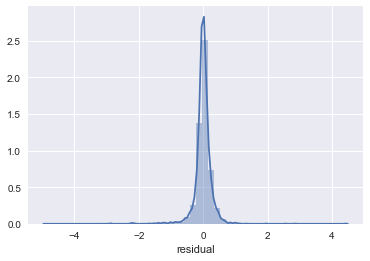

In [15]:
sns.distplot(res.resids)

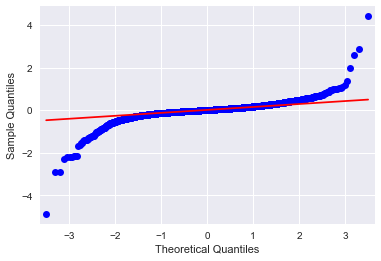

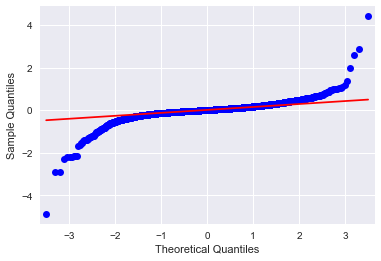

In [16]:
sm.graphics.qqplot(res.resids,line = 'q')

## Calculate FAC

In [17]:
# keep the relevant fields in the data set
app_data = pd.concat([df['RAIL_FLAG'], 
                      res.model.dependent.dataframe, 
                      res.model.exog.dataframe, 
                      res.estimated_effects, 
                      res.resids], axis=1)


In [18]:
# calculate the fitted values
app_data['fitted'] = app_data['effects']
for var in res.params.keys(): 
    app_data['fitted'] = app_data['fitted'] + (res.params[var] * app_data[var])

# and check that we add up correctly
app_data['check_fitted'] = app_data['fitted'] + app_data['residual'] - app_data['UPT_ADJ_log']

In [19]:
# create the necessary columns

# dependents
app_data['UPT_ADJ']    = np.exp(app_data['UPT_ADJ_log']) - 1
app_data['fitted_exp'] = np.exp(app_data['fitted']) - 1

# linear versions of logged variables
for var in res.params.keys(): 
    if '_log' in var: 
        app_data[var.replace('_log', '')] = np.exp(app_data[var]) - 1              

# ratios and differences
for var in res.params.keys(): 
    if '_log' in var: 
        app_data[var.replace('_log', '_ratio')] = 1
    else: 
        app_data[var+'_diff'] = 0

# FAC multipliers
for var in res.params.keys(): 
    app_data[var+'_FAC_ratio'] = 1

app_data['UPT_ADJ_base'] = 0
app_data['UPT_ADJ_ratio'] = 1
app_data['fitted_exp_ratio'] = 1
app_data['UPT_ADJ_diff'] = 0
app_data['fitted_exp_diff'] = 0

In [20]:
# calculate the FAC relative to a specific base year
base_year = 2014
ids = app_data.index.get_level_values(0).unique()

for id in ids: 
    years = app_data.loc[id].index.get_level_values(0)
    
    # special case when base year is not in data--such as Cincinnati rail starting 2016
    if base_year in years: 

        for year in years:         
            for var in res.params.keys(): 
                # ratios and differences
                if '_log' in var: 
                    out_var = var.replace('_log', '_ratio')
                    app_data.loc[(id,year), out_var] = (app_data.loc[(id,year), var] 
                                                     / app_data.loc[(id,base_year), var])
                else: 
                    out_var = var+'_diff'                    
                    app_data.loc[(id,year), out_var] = (app_data.loc[(id,year), var] 
                                                     - app_data.loc[(id,base_year), var])

                # FAC multipliers
                app_data.loc[(id,year),var+'_FAC_ratio'] = np.exp(res.params[var] * (
                                                        app_data.loc[(id,year), var] 
                                                        - app_data.loc[(id,base_year), var]))

                # estimated effects (if time effects is zero, no change)
                app_data.loc[(id,year),'effects_FAC_ratio'] = np.exp(
                                                        app_data.loc[(id,year), 'effects'] 
                                                        - app_data.loc[(id,base_year), 'effects'])

                # residual
                app_data.loc[(id,year),'residual_FAC_ratio'] = np.exp(
                                                        app_data.loc[(id,year), 'residual'] 
                                                        - app_data.loc[(id,base_year), 'residual'])
        
            # observed and fitted changes            
            app_data.loc[(id,year),'UPT_ADJ_base'] = app_data.loc[(id,base_year),'UPT_ADJ']
            app_data.loc[(id,year),'UPT_ADJ_ratio'] = (app_data.loc[(id,year),'UPT_ADJ'] 
                                                     / app_data.loc[(id,base_year),'UPT_ADJ'])
            app_data.loc[(id,year),'fitted_exp_ratio'] = (app_data.loc[(id,year),'fitted_exp'] 
                                                     / app_data.loc[(id,base_year),'fitted_exp'])
            
            app_data.loc[(id,year),'UPT_ADJ_diff'] = (app_data.loc[(id,year),'UPT_ADJ'] 
                                                     - app_data.loc[(id,base_year),'UPT_ADJ'])
            app_data.loc[(id,year),'fitted_exp_diff'] = (app_data.loc[(id,year),'fitted_exp'] 
                                                     - app_data.loc[(id,base_year),'fitted_exp'])


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:17: RuntimeWarning: invalid value encountered in double_scalars
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:17: RuntimeWarning: divide by zero encountered in double_scalars


In [21]:
# calculate the total change ratios

app_data['FAC_ratio'] = 1
for var in res.params.keys(): 
    app_data['FAC_ratio'] = app_data['FAC_ratio'] * app_data[var+'_FAC_ratio']
    
app_data['FAC_ratio'] = app_data['FAC_ratio'] * app_data['effects_FAC_ratio']

In [22]:
# calculate the FAC
app_data['Total_FAC'] = 0
for var in res.params.keys(): 
    app_data[var+'_FAC'] = (app_data[var+'_FAC_ratio'] - 1) * app_data['UPT_ADJ_base']
    app_data['Total_FAC'] = app_data['Total_FAC'] + app_data[var+'_FAC']
app_data['effects_FAC'] = (app_data['effects_FAC_ratio'] - 1) * app_data['UPT_ADJ_base']
app_data['Total_FAC'] = app_data['Total_FAC'] + app_data['effects_FAC']

# scale the FAC
app_data['FAC_scale'] = app_data['fitted_exp_diff'] / app_data['Total_FAC']
app_data['FAC_scale'] = app_data['FAC_scale'].fillna(1)

app_data['Total_FAC_scaled'] = 0
for var in res.params.keys(): 
    app_data[var+'_FAC_scaled'] = app_data[var+'_FAC'] * app_data['FAC_scale']
    app_data['Total_FAC_scaled'] = app_data['Total_FAC_scaled'] + app_data[var+'_FAC_scaled']
app_data['effects_FAC_scaled'] = app_data[var+'_FAC_scaled'] * app_data['FAC_scale']
app_data['Total_FAC_scaled'] = app_data['Total_FAC_scaled'] + app_data['effects_FAC_scaled']


In [23]:
app_data.to_csv('FAC.csv')

PermissionError: [Errno 13] Permission denied: 'FAC.csv'

In [ ]:
# these are the fields we keep
out_fields = ['ID', 'Year', 'RAIL_FLAG', 
              'UPT_ADJ_base', 'UPT_ADJ', 'UPT_ADJ_diff', 
              'fitted_exp', 'fitted_exp_diff']

# exogenous variables 
for var in res.params.keys(): 
    out_var = var.replace('_log', '')
    out_fields = out_fields + [out_var]
    
# FAC
for var in res.params.keys(): 
    out_fields = out_fields + [var+'_FAC']
out_fields = out_fields + ['Total_FAC']
    
# scaled FAC
for var in res.params.keys(): 
    out_fields = out_fields + [var+'_FAC_scaled']
out_fields = out_fields + ['Total_FAC_scaled']

# keep those fields
summary_data = app_data.reset_index()[out_fields]

In [ ]:
# take weighted average of exogenous variables
for var in res.params.keys(): 
    out_var = var.replace('_log', '')
    summary_data[out_var] = summary_data[out_var] * summary_data['UPT_ADJ_base']

# aggregate to bus/rail totals
summary_data = summary_data.groupby(by=['RAIL_FLAG', 'Year']).agg('sum')

# divide for weighted averages
for var in res.params.keys(): 
    out_var = var.replace('_log', '')
    summary_data[out_var] = summary_data[out_var] / summary_data['UPT_ADJ_base']

In [ ]:
summary_data.to_csv('FAC_totals.csv')

In [ ]:
res.params